In [68]:
import torch

from torch import functional as F

In [69]:
import numpy as np

def rolling_window(a, window, step_size):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size + 1, window)
    strides = a.strides + (a.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [70]:
window_size = 20
n_samples = 100

X = np.arange(n_samples, dtype=np.float32)
y = X + window_size
X = rolling_window(X, 20, 1)

In [40]:
data = np.loadtxt('data100.dms', dtype=np.float32, delimiter = ',')

In [41]:
y = data[:, 0]
X = data[:, 1:]

In [42]:
X.shape

(101000, 200)

In [43]:
from torch.utils.data import Dataset

class TimeSeries(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return TimeSeries(self.X[idx], self.y[idx])
        return self.X[idx], self.y[idx]

In [44]:
dataset = TimeSeries(X, y)

In [45]:
dataset[0];

In [82]:
train_idx = 4 * n_samples // 5

# def collate_fn(data):
#     print(len(data))
#     X, y = map(torch.tensor, data)
#     return torch.cat((X, y.reshape(-1, 1)), 1)

train_gen = torch.utils.data.DataLoader(dataset[:train_idx], batch_size=180, shuffle=True)
test_gen = torch.utils.data.DataLoader(dataset[train_idx:], batch_size=180, shuffle=True)

/home/waytobehigh/ds/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/waytobehigh/ds/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [83]:
class Model(torch.nn.Module):
    def __init__(self, hid_size=128):
        super().__init__()
        self._hid_size = hid_size
        self.rnn = torch.nn.LSTM(1, hid_size, 1, batch_first=True)
        self.out = torch.nn.Linear(hid_size, 1)
        self.h0 = torch.randn(self._hid_size)
        self.c0 = torch.randn(self._hid_size)
        
    def forward(self, x):
#         h0 = torch.cat([self.h0] * x.shape[0]).reshape(-1, 1, self._hid_size)
#         c0 = torch.cat([self.c0] * x.shape[0]).reshape(-1, 1, self._hid_size)
        out_rnn, _ = self.rnn(x)
        return self.out(out_rnn[:, -1, :]).view(-1)

In [84]:
model = Model()

In [85]:
from tqdm import tqdm_notebook

losses = []
grads = []
opt = torch.optim.Adam(model.parameters(), 0.01)

for _ in tqdm_notebook(range(100)):
    for batch in train_gen:
        X_batch, y_batch = batch
        X_batch = X_batch.view(*X_batch.shape, 1)
        loss = torch.sqrt(torch.mean((model(X_batch) - y_batch) ** 2))
        loss.backward()
        grads.append(torch.norm(model.rnn.weight_hh_l0, p=2))
        opt.step()
        opt.zero_grad()
        losses.append(loss.data.numpy().item())

In [86]:
print(*(weight.shape for weight in model.rnn.all_weights[0]))

torch.Size([512, 1]) torch.Size([512, 128]) torch.Size([512]) torch.Size([512])


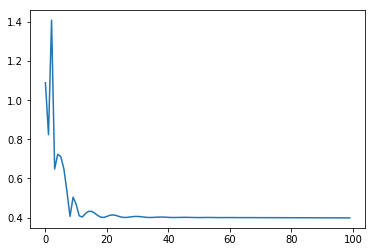

In [87]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

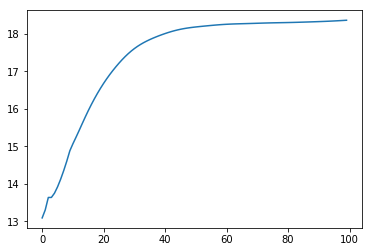

In [88]:
plt.plot(grads)